In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt

# Importing NumPy (Numerical Python) which is a library consisting of multidimensional array objects and a collection of routines for processing those arrays. It also gives an alias to the library.
import numpy as np

% matplotlib inline
np.random.seed(2017) 

# There are two main types of models available in Keras: the Sequential model and the Model class used with the functional API.
# Sequential model is a linear stack of layers. Importing Sequential model from Keras.
from keras.models import Sequential, Model

# Importing different layers from Keras.
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input, Lambda, Concatenate
from keras.layers.normalization import BatchNormalization

# Importing the utils library of Keras.
from keras.utils import np_utils

# Importing the concatenate library of Keras
from keras.layers.merge import concatenate

import tensorflow as tf

# Importing the callbacks of Keras.
from keras.callbacks import ModelCheckpoint

from keras.regularizers import l2

Using TensorFlow backend.


In [0]:
!mv '/content/gdrive/My Drive/cifar-10-python.tar.gz' '/content/cifar-10-batches-py.tar.gz'

In [0]:
!cp '/content/cifar-10-batches-py.tar.gz' ~/.keras/datasets/

In [16]:
ls ~/.keras/datasets

cifar-10-batches-py.tar.gz


In [0]:
# CIFAR10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. Importing CIFAR10 dataset from Keras.
from keras.datasets import cifar10

# Loading the CIFAR10 60000 Training and 10000 Test data into respective numpy arrays
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

# Setting the count, number of channels, rows and columns of training images
num_train, img_channels, img_rows, img_cols =  train_features.shape

# Setting the count of test images
num_test, _, _, _ =  test_features.shape

# Setting number of classes (10)
num_classes = len(np.unique(train_labels))

In [0]:
# Pixel normalization for training images
train_features = train_features.astype('float32')/255

# Pixel normalization for test images
test_features = test_features.astype('float32')/255

# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
# Space_to_depth funcction of Tensorflow rearranges blocks of spatial data into depth. 
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [20]:
# Define the model
input = Input(shape=(32, 32, 3))
layer1 = SeparableConv2D(32, 5, 5, border_mode='same', kernel_regularizer=l2(1e-4))(input) #32,32
layer1 = BatchNormalization()(layer1)
layer1 = Activation('relu')(layer1)
skip_connection1 = layer1 #32,32

#layer2 = Dropout(0.125)(layer1)
layer2 = BatchNormalization()(layer1)
layer2 = Convolution2D(64, 5, 5, border_mode='same', kernel_regularizer=l2(1e-4))(layer2) #32,32
layer2 = Activation('relu')(layer2)
skip_connection2 = layer2

layer3 = BatchNormalization()(layer2)
layer3 = Convolution2D(128, 5, 5, border_mode='same', kernel_regularizer=l2(1e-4))(layer3) #32,32
layer3 = Activation('relu')(layer3)
skip_connection3 = layer3

# Group convolution of layer1 and layer3 to layer4 
groupConv1 = concatenate([skip_connection1, layer3]) #32,32

layer4 = BatchNormalization()(groupConv1)
layer4 = SeparableConv2D(256, 5, 5, border_mode='same', kernel_regularizer=l2(1e-4))(layer4) #32,32
layer4 = Activation('relu')(layer4)
skip_connection4 = layer4

# Group convolution of layer1 and layer4 to layer5
groupConv2 = concatenate([skip_connection1, layer4]) #16,16

# Using 1x1 to reduce channels
layer5 = BatchNormalization()(groupConv2)
layer5 = Convolution2D(32, 1, 1, kernel_regularizer=l2(1e-4))(layer5) #32,32
layer5 = Activation('relu')(layer5)
layer5 = MaxPooling2D(pool_size=(2, 2))(layer5) #16,16

#layer6 = Dropout(0.125)(layer5)
layer6 = BatchNormalization()(layer5)
layer6 = SeparableConv2D(32, 3, 3, border_mode='same', kernel_regularizer=l2(1e-4))(layer6) #16,16
layer6 = Activation('relu')(layer6)
skip_connection6 = layer6 #16,16

# Group convolution of layer1, layer4 and layer6 to layer7
layer1_layer4 = concatenate([skip_connection1, skip_connection4]) #32,32
layer1_layer4 = Lambda(space_to_depth_x2)(layer1_layer4) #16,16
groupConv3 = concatenate([layer1_layer4, layer6]) #16,16

#layer7 = Dropout(0.125)(groupConv3)
layer7 = BatchNormalization()(groupConv3)
layer7 = Convolution2D(64, 5, 5, border_mode='same', kernel_regularizer=l2(1e-4))(layer7) #16,16
layer7 = Activation('relu')(layer7)
skip_connection7 = layer7 #16,16

# Group convolution of layer3, layer4, layer6 and layer7 to layer8
layer3_layer4 = concatenate([skip_connection3, skip_connection4]) #32,32
layer3_layer4 = Lambda(space_to_depth_x2)(layer3_layer4) #16,16
groupConv4 = concatenate([layer3_layer4, layer6, layer7]) #16,16

layer8 = BatchNormalization()(groupConv4)
layer8 = SeparableConv2D(128, 3, 3, border_mode='same', kernel_regularizer=l2(1e-4))(layer8) #16,16
layer8 = Activation('relu')(layer8)
skip_connection8 = layer8 #16,16

# Group convolution of layer1, layer3, layer4, layer6, layer7 and layer8 to layer9
layer1_layer3_layer4 = concatenate([skip_connection1, skip_connection3, skip_connection4]) #32,32
layer1_layer3_layer4 = Lambda(space_to_depth_x2)(layer1_layer3_layer4) #16,16
groupConv5 = concatenate([layer1_layer3_layer4, layer6, layer7, layer8]) #16,16

layer9 = BatchNormalization()(groupConv5)
layer9 = SeparableConv2D(256, 5, 5, border_mode='same', kernel_regularizer=l2(1e-4))(layer9) #16,16
layer9 = Activation('relu')(layer9)

# Group convolution of layer1, layer4, layer6, layer8 and layer9 to layer10
layer1_layer4 = concatenate([skip_connection1, skip_connection4]) #32,32
layer1_layer4 = Lambda(space_to_depth_x2)(layer1_layer4) #16,16
groupConv6 = concatenate([layer1_layer4, layer6, layer8, layer9]) #16,16

# Using 1x1 to reduce channels
layer10 = BatchNormalization()(groupConv6)
layer10 = Convolution2D(32, 1, 1, kernel_regularizer=l2(1e-4))(layer10) #16,16; 16
layer10 = Activation('relu')(layer10)
layer10 = MaxPooling2D(pool_size=(2, 2))(layer10) #8,8

# Group convolution of layer7 and layer10 to layer11
skip_connection_temp7 = Lambda(space_to_depth_x2)(skip_connection7)
groupConv7 = concatenate([skip_connection_temp7, layer10]) #8,8

#layer11 = Dropout(0.125)(groupConv7)
layer11 = BatchNormalization()(groupConv7)
layer11 = Convolution2D(32, 5, 5, border_mode='same', kernel_regularizer=l2(1e-4))(layer11) #8,8
layer11 = Activation('relu')(layer11)
skip_connection11 = layer11 #8,8

# Group convolution of layer2, layer4, layer8 and layer11 to layer12
layer2_layer4 = concatenate([skip_connection2, skip_connection4]) #32,32
layer2_layer4 = Lambda(space_to_depth_x2)(layer2_layer4) #16,16
layer2_layer4_layer8 = concatenate([layer2_layer4, layer8]) #16,16
layer2_layer4_layer8 = Lambda(space_to_depth_x2)(layer2_layer4_layer8) #8,8
groupConv7 = concatenate([layer2_layer4_layer8, layer11]) #8,8

layer12 = BatchNormalization()(groupConv7)
layer12 = SeparableConv2D(64, 5, 5, border_mode='same', kernel_regularizer=l2(1e-4))(layer12) #8,8
layer12 = Activation('relu')(layer12)
skip_connection12 = layer12 #8,8

# Group convolution of layer2, layer3, layer6, layer11 and layer12 to layer13
layer2_layer3 = concatenate([skip_connection2, skip_connection3]) #32,32
layer2_layer3 = Lambda(space_to_depth_x2)(layer2_layer3) #16,16
layer2_layer3_layer6 = concatenate([layer2_layer3, layer6]) #16,16
layer2_layer3_layer6 = Lambda(space_to_depth_x2)(layer2_layer3_layer6) #8,8
groupConv8 = concatenate([layer2_layer3_layer6, layer11, layer12]) #8,8

layer13 = BatchNormalization()(groupConv8)
layer13 = Convolution2D(128, 3, 3, border_mode='same', kernel_regularizer=l2(1e-4))(layer13) #8,8
layer13 = Activation('relu')(layer13)

# Group convolution of layer1, layer3, layer4, layer6, layer8, layer12 and layer13 to layer14
layer1_layer3_layer4 = concatenate([skip_connection1, skip_connection3, skip_connection4]) #32,32
layer1_layer3_layer4 = Lambda(space_to_depth_x2)(layer1_layer3_layer4) #16,16
layer1_layer3_layer4_layer6_layer8 = concatenate([layer1_layer3_layer4, layer6, layer8]) #16,16
layer1_layer3_layer4_layer6_layer8 = Lambda(space_to_depth_x2)(layer1_layer3_layer4_layer6_layer8) #8,8
groupConv9 = concatenate([layer1_layer3_layer4_layer6_layer8, layer12, layer13]) #16,16

layer14 = BatchNormalization()(groupConv9)
layer14 = SeparableConv2D(256, 5, 5, border_mode='same', kernel_regularizer=l2(1e-4))(layer14) #8,8
layer14 = Activation('relu')(layer14)

# Group convolution of layer4, layer8, layer12 and layer14 to softmax
skip_connection_temp1 = Lambda(space_to_depth_x2)(skip_connection1) #16,16
layer4_layer8 = concatenate([skip_connection_temp1, layer8]) #16,16
layer4_layer8 = Lambda(space_to_depth_x2)(layer4_layer8) #8,8
groupConv10 = concatenate([layer4_layer8, layer12, layer14]) #8,8

#layer15 = BatchNormalization()(groupConv10)
layer15 = Convolution2D(10, 1, 1)(groupConv10) #8,8
#layer15 = Activation('relu')(layer15)
layer15 = Convolution2D(10, 8, 8)(layer15) #1,1

output = Flatten()(layer15)
output = Activation('softmax')(output)

W0623 13:08:09.076530 140719482541952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0623 13:08:09.128336 140719482541952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (5, 5), kernel_regularizer=<keras.reg..., padding="same")`
  
W0623 13:08:09.142854 140719482541952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0623 13:08:09.197446 140719482541952 deprecation_wrapper.py:119] Fro

In [26]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 32, 32, 32)   203         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [0]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

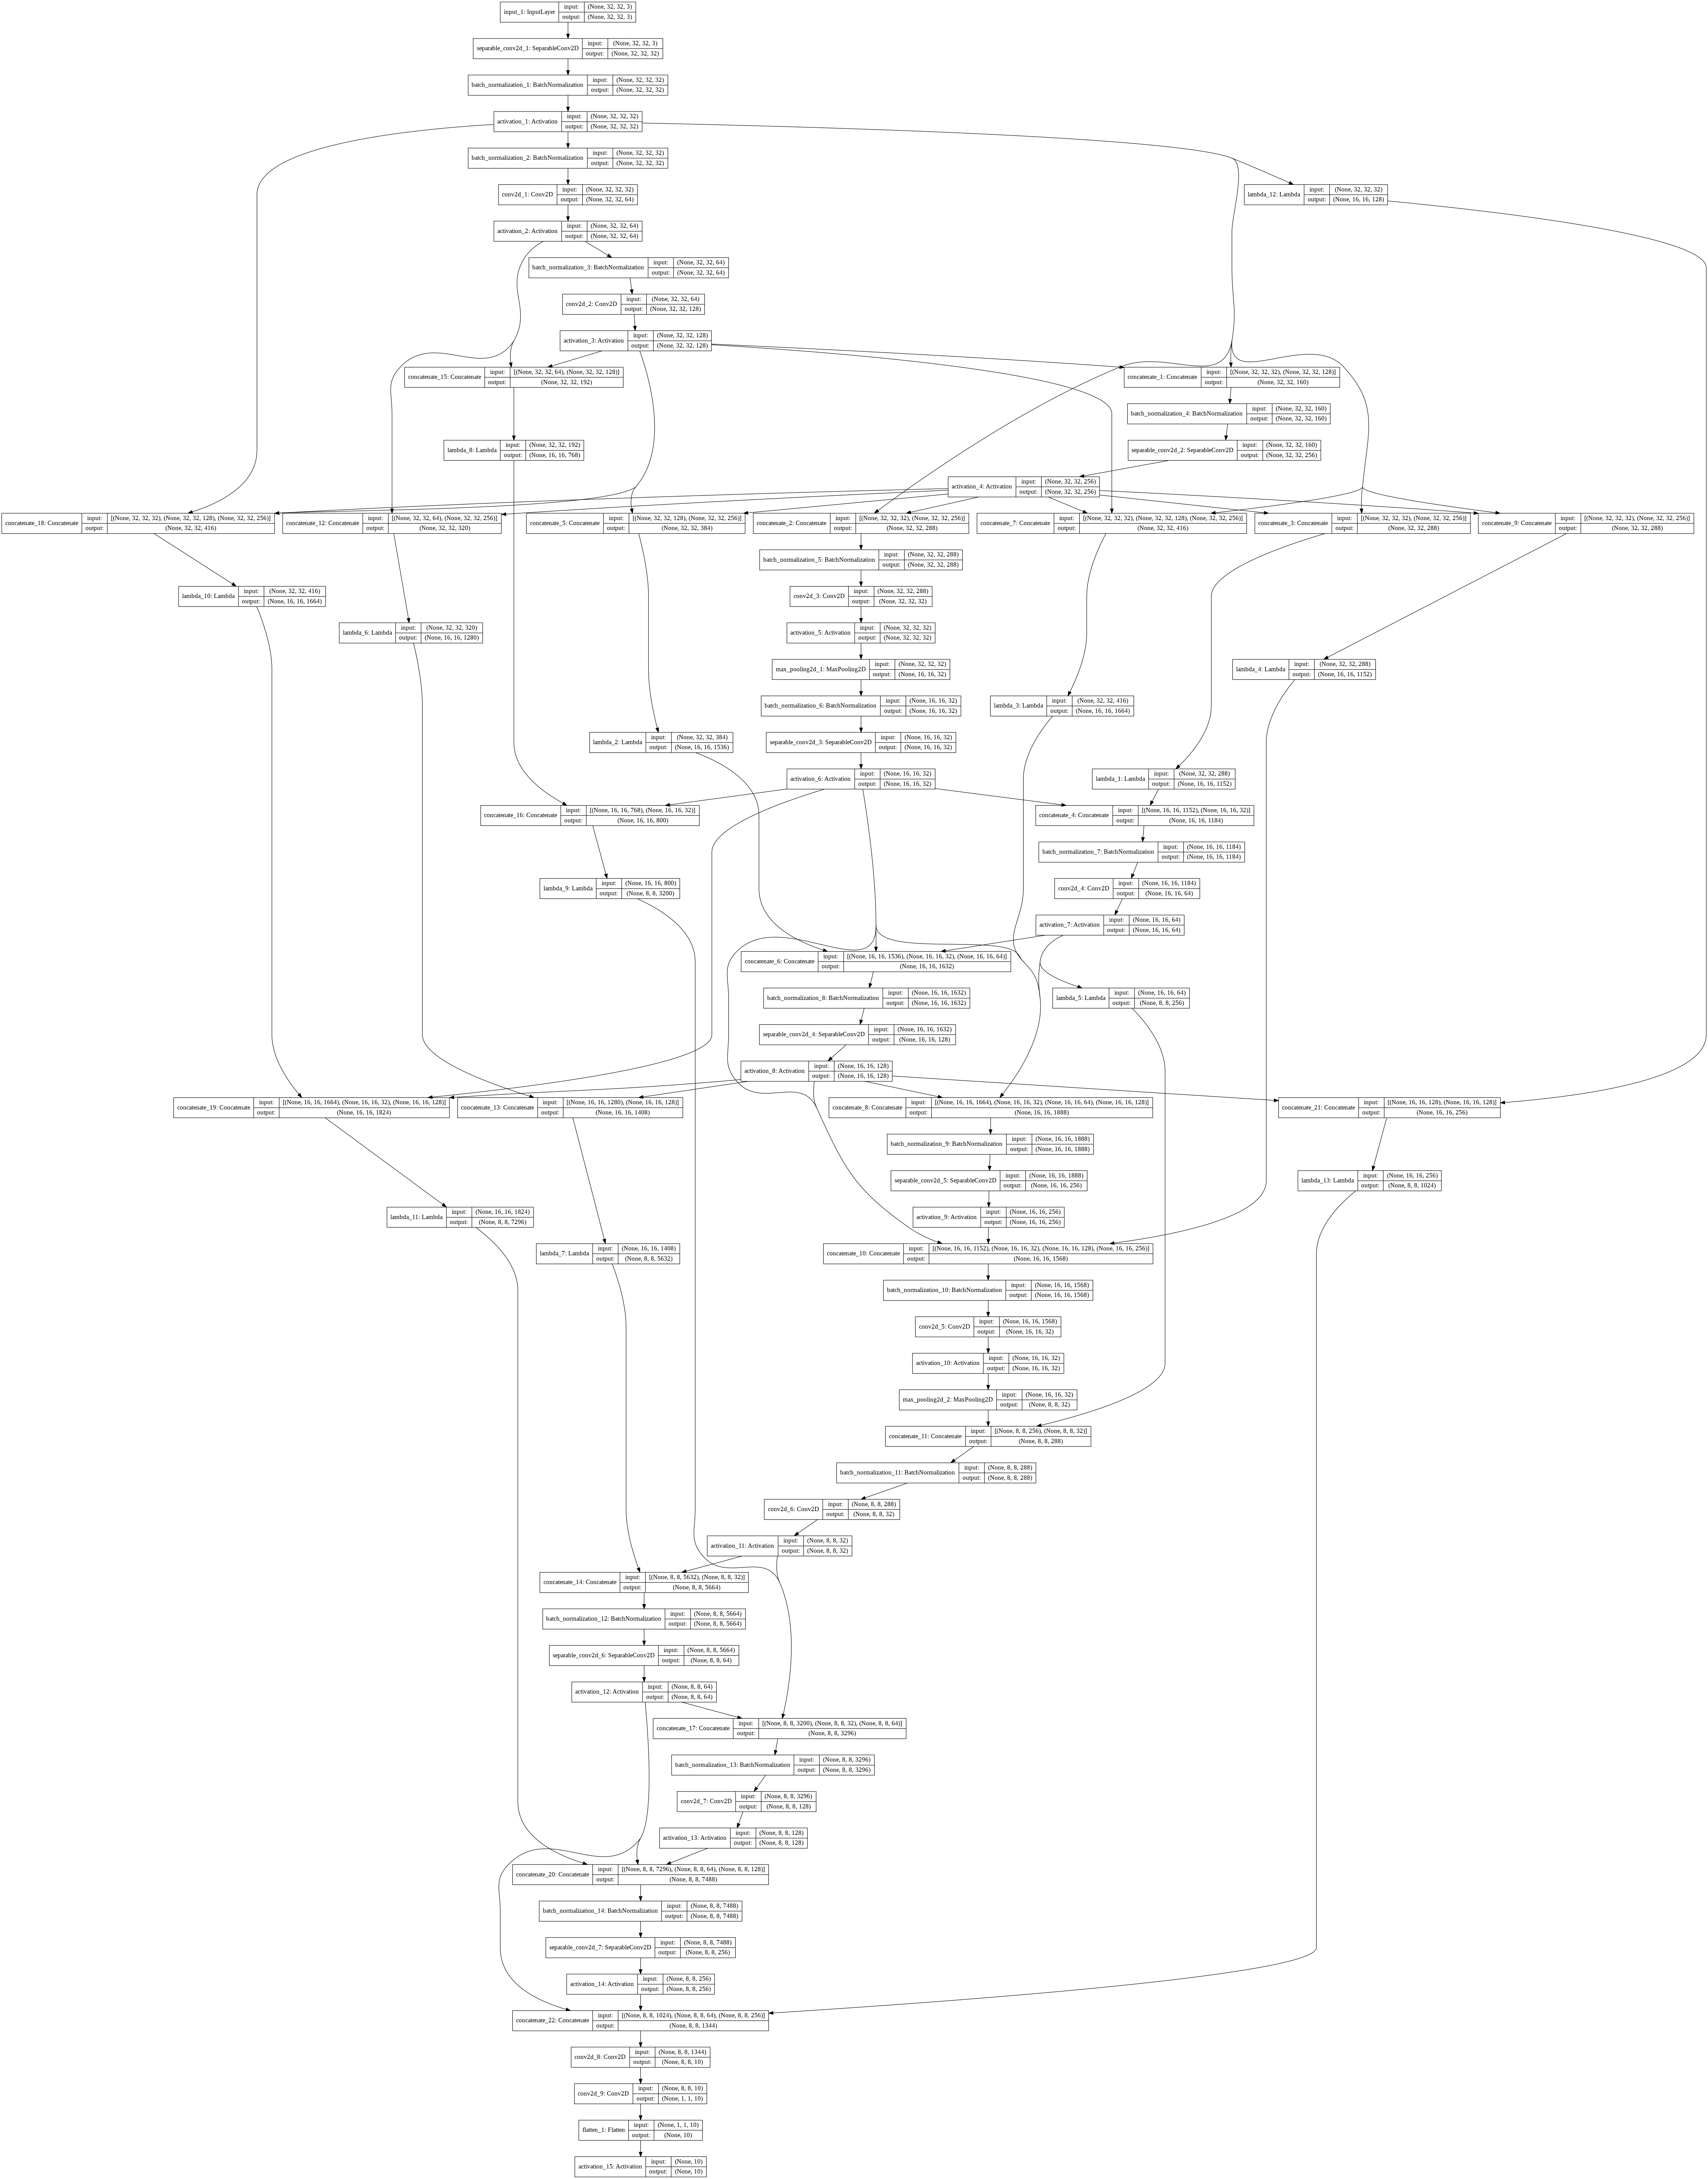

In [8]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_structure.png')

from IPython.display import Image
Image(retina=True, filename='model_structure.png')

In [7]:
# Mounting the Google Drive to save the weights
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Specifying the path to store the weights
filepath="/content/gdrive/My Drive/Assignment7B:{epoch:03d}-val-acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')

In [30]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1,
                                 callbacks=[checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
#plot_model_history(model_info)
# compute test accuracy
#print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  del sys.path[0]
W0623 13:18:33.146205 140719482541952 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is depre

Epoch 1/100
390/390 [==============================] - 221s 566ms/step - loss: 1.3602 - acc: 0.5203 - val_loss: 1.1409 - val_acc: 0.6003

Epoch 00001: val_acc improved from -inf to 0.60030, saving model to /content/gdrive/My Drive/Assignment7B:001-val-acc:0.600.hdf5
Epoch 2/100
390/390 [==============================] - 217s 555ms/step - loss: 0.9073 - acc: 0.6892 - val_loss: 1.0667 - val_acc: 0.6478

Epoch 00002: val_acc improved from 0.60030 to 0.64780, saving model to /content/gdrive/My Drive/Assignment7B:002-val-acc:0.648.hdf5
Epoch 3/100
390/390 [==============================] - 214s 550ms/step - loss: 0.6661 - acc: 0.7761 - val_loss: 0.9237 - val_acc: 0.7066

Epoch 00003: val_acc improved from 0.64780 to 0.70660, saving model to /content/gdrive/My Drive/Assignment7B:003-val-acc:0.707.hdf5
Epoch 4/100
390/390 [==============================] - 214s 550ms/step - loss: 0.4573 - acc: 0.8538 - val_loss: 0.8347 - val_acc: 0.7509

Epoch 00004: val_acc improved from 0.70660 to 0.75090, 

In [27]:
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/Assignment7B:047-val-acc:0.746.hdf5')

ValueError: ignored